In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('preprocessed_trade_data.csv')

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7418 entries, 0 to 7417
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     7418 non-null   int64  
 1   state         7418 non-null   int64  
 2   district      7418 non-null   int64  
 3   market        7418 non-null   int64  
 4   commodity     7418 non-null   int64  
 5   variety       7418 non-null   object 
 6   arrival_date  7418 non-null   object 
 7   min_price     7418 non-null   float64
 8   max_price     7418 non-null   float64
 9   modal_price   7418 non-null   float64
 10  price_spread  7418 non-null   float64
 11  price_ratio   7418 non-null   float64
 12  month         7418 non-null   int64  
 13  day_of_week   7418 non-null   int64  
 14  year          7418 non-null   int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 869.4+ KB
None


In [29]:
sequence_length = 3  # Number of past days to look at for prediction
target_price = 'modal_price'  # Target for price recommendation
features = ['min_price', 'max_price','state','district','market','commodity',
            'price_spread', 'price_ratio', 'month']

In [30]:
# Function to create sequences for LSTM
def create_sequences(data, target_col, features, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

In [31]:
# Filter data for a specific commodity (can be generalized to all)
commodity_id = 1  # Example: Commodity with ID 1
filtered_data = data[data['commodity'] == commodity_id]

In [32]:
# Create sequences for price recommendation
X_price, y_price = create_sequences(filtered_data, target_price, features, sequence_length)

In [33]:
# Split into train and test sets
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

In [34]:
# Function to build and train LSTM models
def build_and_train_lstm(X_train, y_train, X_test, y_test, target_name):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{target_name} Prediction - Training History")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"{target_name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    return model, predictions


Training LSTM for Price Recommendation...
Epoch 1/100


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0175 - mae: 0.1183 - val_loss: 0.0053 - val_mae: 0.0576
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0155 - mae: 0.1102 - val_loss: 0.0038 - val_mae: 0.0555
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0164 - mae: 0.1132 - val_loss: 0.0059 - val_mae: 0.0635
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0145 - mae: 0.1004 - val_loss: 0.0050 - val_mae: 0.0616
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0157 - mae: 0.1087 - val_loss: 0.0031 - val_mae: 0.0535
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0180 - mae: 0.1080 - val_loss: 0.0020 - val_mae: 0.0419
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0147 - mae: 0.0998 - val_loss: 0.0024 - val_mae: 0.0352
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0139 - mae: 0.1033 - val_loss: 0.0034 - val_mae: 0.0512
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0084 - mae: 0.0740

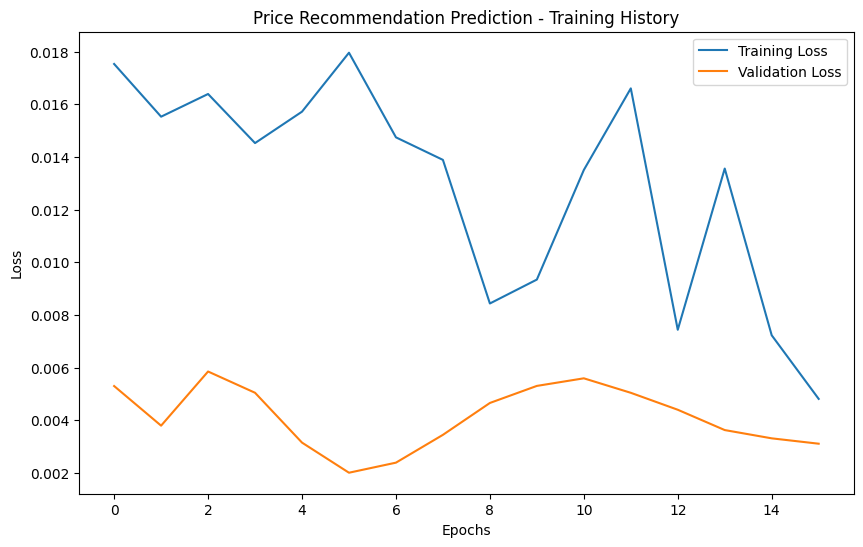

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Price Recommendation - MSE: 0.0020, R2: -21.6157


In [35]:
# Train the LSTM for Price Recommendation
print("\nTraining LSTM for Price Recommendation...")
price_model, price_predictions = build_and_train_lstm(X_price_train, y_price_train, X_price_test, y_price_test, "Price Recommendation")

In [36]:
# Save models
price_model.save("price_recommendation_model.keras")

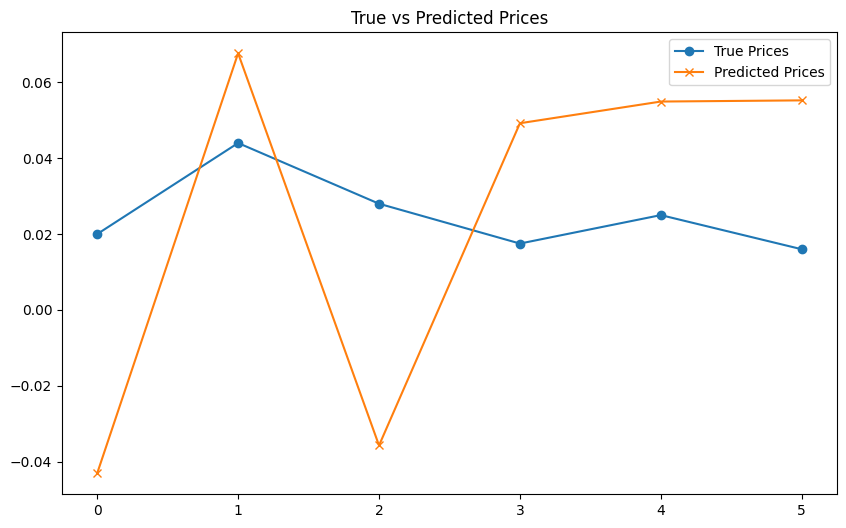

In [37]:
# Example visualization: True vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(y_price_test[:50], label="True Prices", marker='o')
plt.plot(price_predictions[:50], label="Predicted Prices", marker='x')
plt.title("True vs Predicted Prices")
plt.legend()
plt.show()